# 1. Facebook Prophet Testing

## I - Setup

In [1]:
# Import of librairies

import mysql.connector as mariadb
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Importing plotly failed. Interactive plots will not work.


In [2]:
class sql_query:
    def __init__(self, credentials_path):
        self.db_credentials = pd.read_csv(credentials_path, index_col="Field")
      
    
    def __call__(self, query):
        
        mariadb_connection = mariadb.connect(
            user=self.db_credentials.loc["user"][0],
            password=self.db_credentials.loc["password"][0],
            host=self.db_credentials.loc["host"][0],
            port=3306,
            db = "db_velib")
        
        self.cursor = mariadb_connection.cursor()
    
        cursor = self.cursor
        cursor.execute(query)
        field_names = [i[0] for i in cursor.description]
        df = pd.DataFrame(cursor, columns=field_names)
        return df

## II. Adaptation pipeline

In [3]:
# Taking data from  station 9034 - Madeleine

request = sql_query("../../aws_mariadb_crendentials.csv")

query = """
SELECT DISTINCT * FROM velib_realtime
WHERE station_id = 9034
AND date_of_update > DATE("2020-05-05")
ORDER BY date_of_update ASC
"""

df_full = request(query)

In [4]:
df_full.head()

,station_id,operational_station,nb_free_docks,nb_total_free_bikes,nb_free_mechanical_bikes,nb_free_electrical_bikes,payment_totem,bike_return_possible,data_actualisation,date_of_update
0,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:01:00
1,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:02:00
2,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:03:00
3,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:04:00
4,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:05:00


In [5]:
df = df_full[['date_of_update','nb_free_docks']]

# Adopting FB Prophet terminology for easier use
df.columns = ['ds','y']
df.head()

,ds,y
0,2020-05-05 00:01:00,20
1,2020-05-05 00:02:00,20
2,2020-05-05 00:03:00,20
3,2020-05-05 00:04:00,20
4,2020-05-05 00:05:00,20


In [6]:
import seaborn as sns

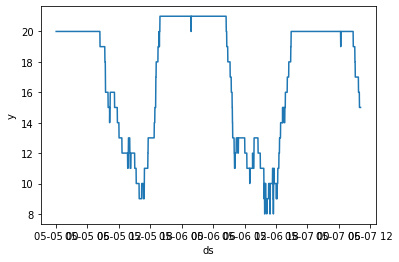

In [7]:
_ = sns.lineplot(x="ds", y="y", data=df)

In [8]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=180, freq='min')
future.tail

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


<bound method NDFrame.tail of                       ds
0    2020-05-05 00:01:00
1    2020-05-05 00:02:00
2    2020-05-05 00:03:00
3    2020-05-05 00:04:00
4    2020-05-05 00:05:00
...                  ...
3662 2020-05-07 13:06:00
3663 2020-05-07 13:07:00
3664 2020-05-07 13:08:00
3665 2020-05-07 13:09:00
3666 2020-05-07 13:10:00

[3667 rows x 1 columns]>

In [9]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3662,2020-05-07 13:06:00,13.825313,12.679712,14.995006
3663,2020-05-07 13:07:00,13.833156,12.688906,14.957956
3664,2020-05-07 13:08:00,13.840946,12.584397,14.952374
3665,2020-05-07 13:09:00,13.848679,12.694402,15.015255
3666,2020-05-07 13:10:00,13.856351,12.769412,15.016456


In [10]:
forecast_full = forecast
forecast_full['y'] = df['y']
# Replacing y Nan values with last values known
# forecast_full['y'].iloc[df.shape[0]:] = forecast_full['y'].iloc[df.shape[0]-1]
forecast_full['yhat_round'] = forecast_full['yhat'].apply(lambda x: round(x))

In [11]:
forecast_full.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,yhat_round
0,2020-05-05 00:01:00,15.353954,19.040571,20.639259,15.353954,15.353954,4.466073,4.466073,4.466073,4.466073,4.466073,4.466073,0.0,0.0,0.0,19.820026,20.0,20
1,2020-05-05 00:02:00,15.358697,18.998324,20.615585,15.358697,15.358697,4.461182,4.461182,4.461182,4.461182,4.461182,4.461182,0.0,0.0,0.0,19.819879,20.0,20
2,2020-05-05 00:03:00,15.363440,19.048025,20.628790,15.363440,15.363440,4.456401,4.456401,4.456401,4.456401,4.456401,4.456401,0.0,0.0,0.0,19.819841,20.0,20
3,2020-05-05 00:04:00,15.368184,19.011145,20.637071,15.368184,15.368184,4.451728,4.451728,4.451728,4.451728,4.451728,4.451728,0.0,0.0,0.0,19.819911,20.0,20
4,2020-05-05 00:05:00,15.372927,18.992539,20.548710,15.372927,15.372927,4.447163,4.447163,4.447163,4.447163,4.447163,4.447163,0.0,0.0,0.0,19.820090,20.0,20


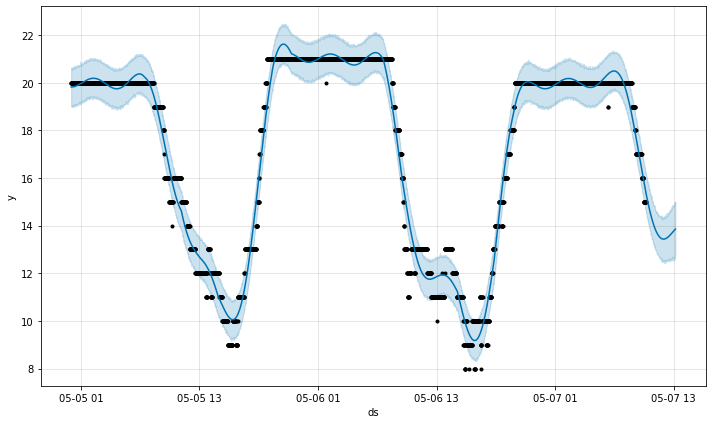

In [12]:
fig1 = m.plot(forecast)

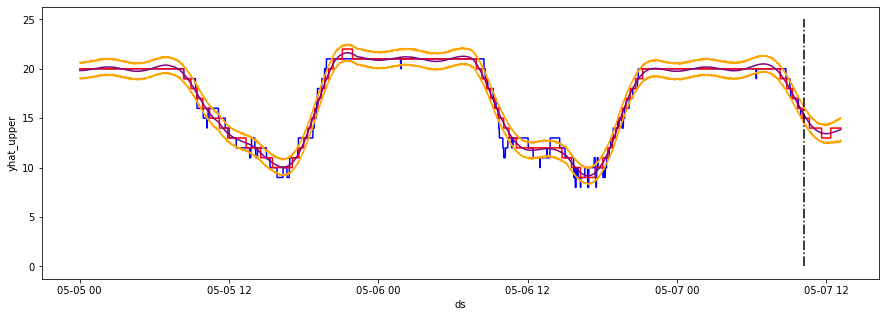

In [13]:
fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x="ds", y="y",data=forecast_full, color="blue")
sns.lineplot(x="ds", y="yhat_round",data=forecast_full, color="red")
sns.lineplot(x="ds", y="yhat",data=forecast_full, color="purple")
sns.lineplot(x="ds", y="yhat_lower",data=forecast_full, color="orange")
sns.lineplot(x="ds", y="yhat_upper",data=forecast_full, color="orange")

x1, y1 = [forecast_full.ds.iloc[df.shape[0]], forecast_full.ds.iloc[df.shape[0]]], [0, 25]
ax = plt.plot(x1, y1, linestyle="dashdot", color="black")

plt.show()


In [14]:
forecast_full[-180*2:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,yhat_round
3307,2020-05-07 07:11:00,17.523631,19.669175,21.237657,17.523631,17.523631,2.943910,2.943910,2.943910,2.943910,2.943910,2.943910,0.0,0.0,0.0,20.467541,20.0,20
3308,2020-05-07 07:12:00,17.528847,19.684361,21.269110,17.528847,17.528847,2.934829,2.934829,2.934829,2.934829,2.934829,2.934829,0.0,0.0,0.0,20.463676,20.0,20
3309,2020-05-07 07:13:00,17.534064,19.654523,21.284910,17.534064,17.534064,2.925455,2.925455,2.925455,2.925455,2.925455,2.925455,0.0,0.0,0.0,20.459519,20.0,20
3310,2020-05-07 07:14:00,17.539281,19.671480,21.232885,17.539281,17.539281,2.915785,2.915785,2.915785,2.915785,2.915785,2.915785,0.0,0.0,0.0,20.455066,20.0,20
3311,2020-05-07 07:15:00,17.544498,19.654756,21.264655,17.544498,17.544498,2.905816,2.905816,2.905816,2.905816,2.905816,2.905816,0.0,0.0,0.0,20.450314,20.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3662,2020-05-07 13:06:00,19.375610,12.679712,14.995006,18.614390,20.158049,-5.550297,-5.550297,-5.550297,-5.550297,-5.550297,-5.550297,0.0,0.0,0.0,13.825313,NaN,14
3663,2020-05-07 13:07:00,19.380827,12.688906,14.957956,18.613095,20.173509,-5.547671,-5.547671,-5.547671,-5.547671,-5.547671,-5.547671,0.0,0.0,0.0,13.833156,NaN,14
3664,2020-05-07 13:08:00,19.386043,12.584397,14.952374,18.611800,20.187612,-5.545097,-5.545097,-5.545097,-5.545097,-5.545097,-5.545097,0.0,0.0,0.0,13.840946,NaN,14
3665,2020-05-07 13:09:00,19.391260,12.694402,15.015255,18.610505,20.197815,-5.542581,-5.542581,-5.542581,-5.542581,-5.542581,-5.542581,0.0,0.0,0.0,13.848679,NaN,14


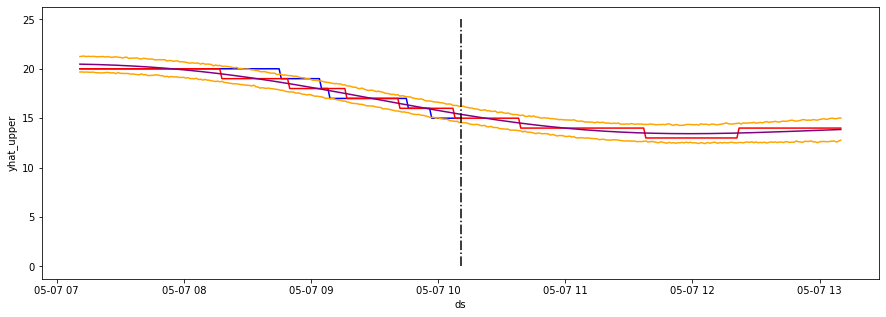

In [15]:
fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x="ds", y="y",data=forecast_full[-180*2:], color="blue")
sns.lineplot(x="ds", y="yhat_round",data=forecast_full[-180*2:], color="red")
sns.lineplot(x="ds", y="yhat",data=forecast_full[-180*2:], color="purple")
sns.lineplot(x="ds", y="yhat_lower",data=forecast_full[-180*2:], color="orange")
sns.lineplot(x="ds", y="yhat_upper",data=forecast_full[-180*2:], color="orange")

x1, y1 = [forecast_full.ds.iloc[df.shape[0]], forecast_full.ds.iloc[df.shape[0]]], [0, 25]
ax = plt.plot(x1, y1, linestyle="dashdot", color="black")

plt.show()
